In [27]:
# Import of libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

In [28]:
no_train = False
fashion = False
batch_size = 128
n_epochs = 20
lr = 0.001
store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"

In [29]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [30]:
# Shows a batch of images
def show_batch(loader,batch_index=0):
    for i, batch in enumerate(loader):
        if i == batch_index:
            images, _ = batch  # 你也可以不解包，视你的 dataset 而定
            show_images(images, f"Images in batch {batch_index}")
            break

In [31]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
ds_fn = FashionMNIST if fashion else MNIST
dataset = ds_fn("../../assets", download=False, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [32]:
# show_batch(loader,3)

In [33]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	NVIDIA GeForce RTX 4060 Laptop GPU


In [34]:
# ----- Sinusoidal Time Embedding -----
def sinusoidal_embedding(n, d):
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)]).reshape(1, d)
    t = torch.arange(n).reshape(n, 1)
    embedding[:, 0::2] = torch.sin(t * wk[:, 0::2])
    embedding[:, 1::2] = torch.cos(t * wk[:, 1::2])
    return embedding

In [35]:
# ----- VAE MODULES -----
class VAEEncoder(nn.Module):
    def __init__(self, z_channels=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, z_channels * 2, 3, padding=1)
        )

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z, mu, logvar

In [36]:
class VAEDecoder(nn.Module):
    def __init__(self, z_channels=4):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(z_channels, 64, 4, stride=2, padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(32, 1, 3, padding=1),
        )

    def forward(self, z):
        return self.decoder(z)

In [37]:
# ----- Self-Attention Block -----
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels, 1)
        self.key = nn.Conv2d(in_channels, in_channels, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.out = nn.Conv2d(in_channels, in_channels, 1)
        self.scale = in_channels ** -0.5

    def forward(self, x):
        B, C, H, W = x.shape
        q = self.query(x).reshape(B, C, H * W)
        k = self.key(x).reshape(B, C, H * W)
        v = self.value(x).reshape(B, C, H * W)

        attn = torch.bmm(q.permute(0, 2, 1), k) * self.scale
        attn = attn.softmax(dim=-1)

        out = torch.bmm(v, attn.permute(0, 2, 1)).reshape(B, C, H, W)
        return self.out(out + x)

In [38]:
# ----- Tiny UNet with Attention -----
class TinyUNetWithAttention(nn.Module):
    def __init__(self, n_steps=200, time_emb_dim=100, in_channels=4):
        super().__init__()
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        self.time_proj = nn.Sequential(
            nn.Linear(time_emb_dim, 7 * 7),
            nn.SiLU()
        )

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels + 1, 64, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.SiLU(),
            SelfAttention(128),
            nn.SiLU()
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, in_channels, 3, padding=1)
        )

    def forward(self, x, t):
        n = x.shape[0]
        t = t.view(-1)
        t_emb = self.time_proj(self.time_embed(t)).view(n, 1, 7, 7)
        x = torch.cat([x, t_emb], dim=1)
        h = self.encoder(x)
        out = self.decoder(h)
        return out

In [39]:
def generate_new_images(ddpm, n_samples=16, device=None, gif_name="sampling.gif", frames_per_gif=100):
    """For LatentDiffusion: Samples latent → decode → make GIF"""
    if device is None:
        device = ddpm.device

    frames = []
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)

    with torch.no_grad():
        # Step 1: sample latent space denoising (return intermediate x_t at each step)
        x = torch.randn(n_samples, 4, 7, 7).to(device)
        all_frames = []

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            time_tensor = torch.full((n_samples,), t, dtype=torch.long, device=device)
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn_like(x)
                sigma_t = ddpm.betas[t].sqrt()
                x = x + sigma_t * z

            if idx in frame_idxs or t == 0:
                decoded = ddpm.decoder(x)
                normalized = decoded.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)
                frames.append(frame)

    # Write GIF
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            rgb_frame = np.repeat(frame, 3, axis=2)
            writer.append_data(rgb_frame)
            if idx == len(frames) - 1:
                last_rgb_frame = np.repeat(frames[-1], 3, axis=2)
                for _ in range(frames_per_gif // 3):
                    writer.append_data(last_rgb_frame)
    
    return ddpm.decoder(x)  # Return final decoded output for further use


In [ ]:
import torch.nn.functional as F
# ----- Latent Diffusion Wrapper -----
class LatentDiffusion(nn.Module):
    def __init__(self, unet_model, encoder, decoder, n_steps=200, min_beta=1e-4, max_beta=0.02, device=None):
        super().__init__()
        self.device = device
        self.n_steps = n_steps
        self.unet = unet_model.to(device)
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)

        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(n_steps)]).to(device)

    def forward(self, x0, t, eta=None):
        z0, mu, logvar = self.encoder(x0)
        a_bar = self.alpha_bars[t].reshape(-1, 1, 1, 1).to(self.device)
        if eta is None:
            eta = torch.randn_like(z0)
        noisy = a_bar.sqrt() * z0 + (1 - a_bar).sqrt() * eta
        return noisy, eta, mu, logvar

    def backward(self, z, t):
        return self.unet(z, t)

    def sample(self, n_samples, c=4, h=7, w=7):
        x = torch.randn(n_samples, c, h, w).to(self.device)
        with torch.no_grad():
            for t in reversed(range(self.n_steps)):
                time_tensor = torch.full((n_samples,), t, device=self.device, dtype=torch.long)
                eta_theta = self.backward(x, time_tensor)
                alpha_t = self.alphas[t]
                alpha_t_bar = self.alpha_bars[t]
                x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)
                if t > 0:
                    z = torch.randn_like(x)
                    sigma_t = self.betas[t].sqrt()
                    x = x + sigma_t * z
        return self.decoder(x)

    def loss_function(self, eta_theta, eta, mu, logvar):
        recon_loss = F.mse_loss(eta_theta, eta)
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + 1e-1 * kl_loss


In [41]:
encoder = VAEEncoder(z_channels=4)
decoder = VAEDecoder(z_channels=4)
unet = TinyUNetWithAttention(in_channels=4)

ldm = LatentDiffusion(unet, encoder, decoder, n_steps=200, device=device)


In [42]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ldm_model.pt"):
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc="Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # 1. 载入数据
            x0 = batch[0].to(device)
            n = len(x0)

            # 2. 随机时间步 + noise
            t = torch.randint(0, n_steps, (n,), device=device)
            eta = torch.randn(n, 4, 7, 7, device=device)  # latent shape

            # 3. 执行 forward 扩散（获得噪声图和 VAE stats）
            noisy_z, true_eta, mu, logvar = ddpm(x0, t, eta)

            # 4. 反向网络预测噪声
            eta_theta = ddpm.backward(noisy_z, t)

            # 5. 计算 loss：预测噪声 vs 真正噪声 + KL
            loss = ddpm.loss_function(eta_theta, true_eta, mu, logvar)

            # 6. 优化器步骤
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * n / len(loader.dataset)

        # 7. 可视化或保存最佳模型
        if display:
            show_images(ddpm.sample(16), f"Generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model saved"
        print(log_string)


In [43]:
# Training
store_path = "ddpm_mlp_fashion.pt" if fashion else "ddpm_mlp_mnist.pt"
if not no_train:
    training_loop(ldm, loader, n_epochs, optim=Adam(ldm.parameters(), lr), device=device, store_path=store_path)

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 1: 0.170 --> Best model saved


Epoch 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 2: 0.038 --> Best model saved


Epoch 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 3: 0.021 --> Best model saved


Epoch 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 4: 0.019 --> Best model saved


Epoch 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 5: 0.012 --> Best model saved


Epoch 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 6: 0.011 --> Best model saved


Epoch 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 7: 0.008 --> Best model saved


Epoch 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 8: 0.006 --> Best model saved


Epoch 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 9: 0.006 --> Best model saved


Epoch 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 10: 0.005 --> Best model saved


Epoch 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 11: 0.004 --> Best model saved


Epoch 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 12: 0.004 --> Best model saved


Epoch 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 13: 0.004 --> Best model saved


Epoch 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 14: 0.003 --> Best model saved


Epoch 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 15: 0.003 --> Best model saved


Epoch 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 16: 0.003


Epoch 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 17: 0.003 --> Best model saved


Epoch 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 18: 0.003 --> Best model saved


Epoch 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 19: 0.003


Epoch 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 20: 0.002 --> Best model saved


In [44]:
# Loading the trained model
best_model = LatentDiffusion(unet, encoder, decoder, n_steps=200, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


C:\Users\zhang\AppData\Local\Temp\ipykernel_26324\2907953636.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(store_path, map_locati

Generating new images


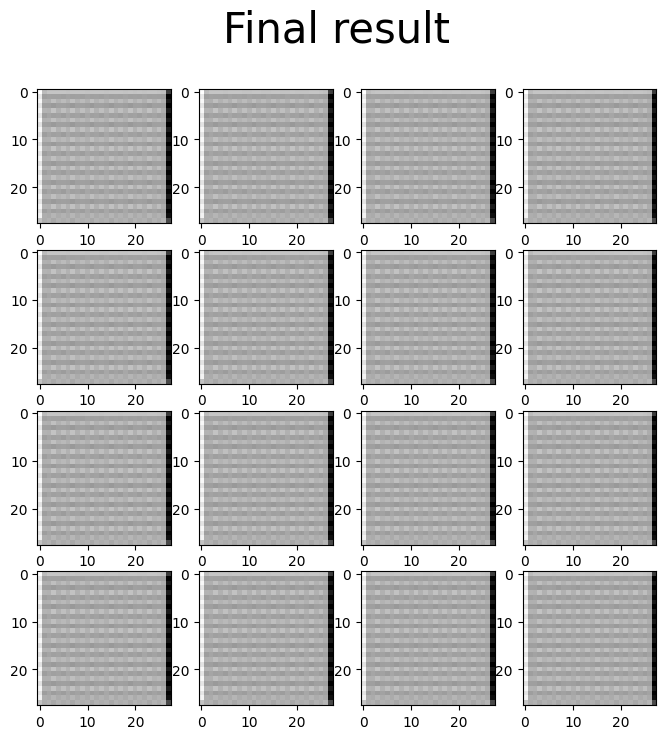

In [45]:
print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=16,
        device=device,
        gif_name="fashion.gif" if fashion else "mnist.gif"
    )
show_images(generated, "Final result")

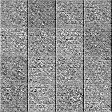

In [46]:
from IPython.display import Image

Image(open('fashion.gif' if fashion else 'mnist.gif','rb').read())

In [48]:
samples = best_model.sample(8)
print(torch.min(samples), torch.max(samples), torch.mean(samples))


tensor(-0.0230, device='cuda:0', grad_fn=<MinBackward1>) tensor(-0.0017, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.0089, device='cuda:0', grad_fn=<MeanBackward0>)
